In [1]:
""" 와인 데이터 정리 """
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df_wine = pd.read_csv('../Dataset/wine.data', header = None)
df_wine.columns = ['Class label', 'Alcohol',
                  'Malic acid', 'Ash',
                  'Alcalinity of ash', 'Magnesium',
                  'Total phenols', 'Flavanoids',
                  'Nonflavanoid phenols',
                  'Proanthocyanins',
                  'Color intensity', 'Hue',
                  'OD280/OD315 of diluted wines',
                  'Proline']

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                   stratify = y, random_state = 0)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)

In [2]:
""" 평균 벡터 구하기 """
import numpy as np

np.set_printoptions(precision = 4)
mean_vecs = []

for label in range(1,4) :
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis = 0))
    print('MV %s: %s\n' %(label, mean_vecs[label-1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



In [3]:
""" 클래스 내 산포 행렬 구하기 """

d = 13
S_W = np.zeros((d, d))

for label, mv in zip(range(1, 4), mean_vecs) :
    class_scatter = np.zeros((d, d))
    
    for row in X_train_std[y_train == label] :
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)
    
    S_W += class_scatter

print('클래스 내의 산포 행렬 : %s*%s' % (S_W.shape[0], S_W.shape[1]))
print('클래스 레이블 분포 : %s' % np.bincount(y_train)[1:])
# 스케일 조정이 되지 않은 상태이다.

클래스 내의 산포 행렬 : 13*13
클래스 레이블 분포 : [41 50 33]


In [4]:
""" 공분산을 이용하여 산포 행렬 구하기 """

d = 13
S_W = np.zeros((d, d))

for label, mv in zip(range(1, 4), mean_vecs) :
    class_scatter = np.cov(X_train_std[y_train == label].T, bias = True)
    S_W += class_scatter
print('스케일 조정된 클래스 내의 산포 행렬 : %s*%s' % (S_W.shape[0], S_W.shape[1]))

스케일 조정된 클래스 내의 산포 행렬 : 13*13


In [7]:
""" 클래스 간의 산포 행렬 구하기 """

mean_overall = np.mean(X_train_std, axis = 0)
mean_overall = mean_overall.reshape(d, 1)
# 열벡터화
d = 13
S_B = np.zeros((d, d))

for i, mean_vec in enumerate(mean_vecs) : 
    # Remind : enumerate는 반복 가능한 객체(문자열, 리스트, 넘파이 배열 등)를 입력으로 받아 인덱스와 값의 튜플을
    # 차례대로 반환하는 파이썬 내장함수이다.
    n = X_train[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('클래스 간의 산포 행렬 : %s*%s' % (S_B.shape[0], S_B.shape[1]))

클래스 간의 산포 행렬 : 13*13


In [8]:
""" 산포 행렬 고윳값 계산 """

eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key = lambda k: k[0], reverse = True)
print('내림차순의 고윳값 : \n')

for eigen_val in eigen_pairs : 
    print(eigen_val[0])
    
print('\n0이 아닌 고윳값은 위의 2개뿐으로, 남은 것은 부동 소수 연산에 의한 값이다.')

내림차순의 고윳값 : 

358.0042070133658
177.07768640666217
2.842170943040401e-14
2.416464785473244e-14
2.1954926639581513e-14
2.1954926639581513e-14
2.0367938670394332e-14
2.0367938670394332e-14
1.8639642080179956e-14
1.4017013569391021e-14
1.4017013569391021e-14
3.5106142861573525e-15
2.728065685424338e-15

0이 아닌 고윳값은 위의 2개뿐으로, 남은 것은 부동 소수 연산에 의한 값이다.


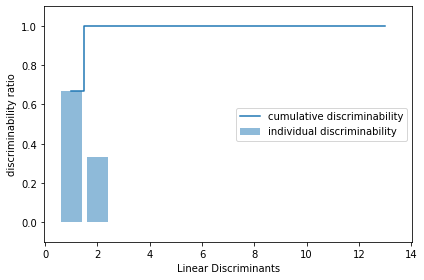


 두 개의 선형 판별 벡터가 거의 모든 정보를 잡아낸다.


In [9]:
""" 선형 판별 벡터 그리기 """
import matplotlib.pyplot as plt

tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse = True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, alpha = 0.5, align = 'center',
       label = 'individual discriminability')
# 식별 가능성
plt.step(range(1, 14), cum_discr, where = 'mid',
        label = 'cumulative discriminability')
plt.ylabel('discriminability ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

print('\n 두 개의 선형 판별 벡터가 거의 모든 정보를 잡아낸다.')

In [10]:
""" 변환 행렬 W 만들기 """

w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real))
# 두개의 판별 고유 벡터를 열로 쌓아 변환 행렬을 만든다.
print('행렬 W : \n', w)


행렬 W : 
 [[-0.1484 -0.4093]
 [ 0.091  -0.1583]
 [-0.0168 -0.3536]
 [ 0.1487  0.322 ]
 [-0.0165 -0.0813]
 [ 0.1912  0.0841]
 [-0.7333  0.2828]
 [-0.0751 -0.0099]
 [ 0.002   0.0902]
 [ 0.2953 -0.2168]
 [-0.0327  0.274 ]
 [-0.3539 -0.0133]
 [-0.3918 -0.5954]]


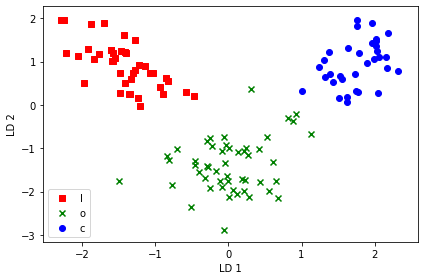

In [11]:
""" 새로운 특성 공간으로 샘플 투영 """

X_train_lda = X_train_std.dot(w)
colors = ['r', 'g', 'b']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers) :
    plt.scatter(X_train_lda[y_train == l, 0], X_train_lda[y_train == l, 1] * (-1),
               c = c, label = l, marker = m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend('loc = lower right')
plt.tight_layout()
plt.show()

In [12]:
""" 시각화 함수 """
from matplotlib.colors import ListedColormap

# 2차원 데이터셋의 결정 경계를 시각화
def plot_decision_regions(X, y, classifier, test_idx = None, resolution = 0.02) :
    
    # 마커와 컬러맵 설정
    markers = ('s', 'x', 'o', '^', ' v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # 결정 경계 그리기
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha = 0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # 샘플의 산점도
    for idx, cl in enumerate(np.unique(y)) :
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha = 0.8, c = colors[idx], marker = markers[idx],
                   label = cl, edgecolor = 'black')
    
    # 테스트 샘플을 부각
    if test_idx : 
        X_test, y_test = X[test_idx, :], y[test_idx]
        
        plt.scatter(X_test[:, 0], X_test[:, 1], c = '', edgecolor = 'black', alpha = 1.0,
                   linewidth = 1, marker = 'o', s = 100, label = 'test set')

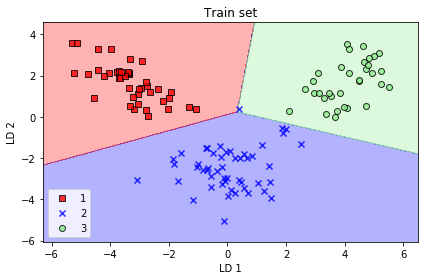

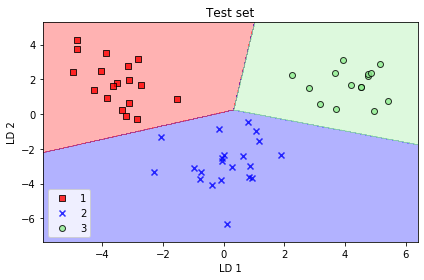

In [13]:
""" 사이킷 런 LDA """
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression

lda = LDA(n_components = 2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

# 로지스틱 회귀로 테스트하기
lr = LogisticRegression(solver = 'liblinear', multi_class = 'auto')
lr = lr.fit(X_train_lda, y_train)
plot_decision_regions(X_train_lda, y_train, classifier = lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc = 'lower left')
plt.title('Train set')
plt.tight_layout()
plt.show()

X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier = lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc = 'lower left')
plt.title('Test set')
plt.tight_layout()
plt.show()

In [14]:
""" 사이킷 런의 LDA 구현 """
import scipy

# 클래스 내 산포 행렬 계산
y_uniq, y_count = np.unique(y_train, return_counts = True)
priors = y_count / X_train_std.shape[0]
print(priors)

s_w = np.zeros((X_train_std.shape[1], X_train_std.shape[1]))
for i, label in enumerate(y_uniq):
    s_w += priors[i] * np.cov(X_train_std[y_train == label].T, bias=True)
    # bias = True에 의해 공분산 계산시 1/(n-1)을 곱하던 것을 1/n으로 바꿀 수 있다.

# 클래스 간 산포 행렬 계산
s_b = np.zeros((X_train_std.shape[1], X_train_std.shape[1]))

for i, mean_vec in enumerate(mean_vecs):
    n = X_train_std[y_train == i + 1].shape[0]
    mean_vec = mean_vec.reshape(-1, 1)
    s_b += priors[i] * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

# scipy를 사용하여 고윳값 계산
ei_val, ei_vec = scipy.linalg.eigh(s_b, s_w)
ei_vec = ei_vec[:, np.argsort(ei_val)[::-1]]
#ei_vec = ((np.array(ei_vec)).argsort()[::-1]) * 1.0
ei_vec /= np.linalg.norm(ei_vec, axis = 0)
#np.sqrt(np.dot(ei_vec.ravel(),ei_vec.ravel()))

# LDA 클래스와 같은지 확인
lda_eigen = LDA(solver = 'eigen')
lda_eigen.fit(X_train_std, y_train)
print(np.allclose(s_w, lda_eigen.covariance_))

# 클래스 간 산포 행렬 S_B 구하기
Sb = np.cov(X_train_std.T, bias=True) - lda_eigen.covariance_
print(np.allclose(Sb, s_b))

"""
ei_vec 의 argsort가 정상작동하지 않아 eigen vector 값이 달라져 True값이 나오지 않는다.
이전의 해결했던 argsort() 해결 방법으로는 해결되지 않음을 확인하였고,
norm 함수를 대체해봐도 해결되지 않는다.
"""

#선형 판별 벡터 비교하기
print(np.allclose(lda_eigen.scalings_[:, :2], ei_vec[:, :2]))
# scalings_ 속성에 고유 벡터가 저장된다.

# transform 메소드를 벡터 점곱으로 구현
print(np.allclose(lda_eigen.transform(X_test_std), np.dot(X_test_std, ei_vec[:, :2])))

[0.3306 0.4032 0.2661]
True
True
False
False
